In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
import re
from nltk.corpus import stopwords
from gensim import corpora
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import euclidean_distances
from scipy.cluster.hierarchy import ward, dendrogram,fcluster

In [2]:
col_event_split = ['id','userId', 'createdAt', 'text', 'longitude', 'latitude', 'placeId', 'inReplyTo', 'placeLatitude', 'placeLongitude']

In [3]:
parse_dates = ['createdAt']

In [4]:
tweets = pd.read_csv('../twitter-swisscom/twex_event_corrected.tsv', sep="\t", encoding='utf-8', escapechar='\\', names=col_event_split, parse_dates=parse_dates, na_values='N', header=None, nrows=10000)

In [5]:
tweets.head()

,id,userId,createdAt,text,longitude,latitude,placeId,inReplyTo,placeLatitude,placeLongitude
0,9514097914,17341045,2010-02-23 05:55:51,Guuuuten Morgen! :-),7.43926,46.9489,NaN,NaN,NaN,NaN
1,9514846412,7198282,2010-02-23 06:22:40,Still the best coffee in town — at La Stanza h...,8.53781,47.3678,NaN,NaN,NaN,NaN
2,9516574359,14657884,2010-02-23 07:34:25,It has been a week or so.. and today I just co...,6.13396,46.1951,NaN,NaN,NaN,NaN
3,9516952605,14703863,2010-02-23 07:51:47,Getting ready.. http://twitpic.com/14v8gz,8.81749,47.2288,NaN,NaN,NaN,NaN
4,9517198943,14393717,2010-02-23 08:02:57,Un peu de réconfort liquide en take away après...,6.63254,46.5199,NaN,NaN,NaN,NaN


Different informations on the longitude and latitude are given, the columns longitude/latitude are the position of the Tweet as reported by the user or client application. The place longitude/latitude is  indicates that the tweet is associated (but not necessarily originating from) a Place. And as we can see on the head of the table, the place is not always set.

We decided to use the longitude/latitude columns to represent the position of a tweet and if they are null we will use the placeLatitude and placeLongitude. If both are null we will have to drop the entry as a tweet without position is not usefull for event detection.

In [6]:
print(tweets.shape)
tweets.dtypes

(10000, 10)


id                         int64
userId                     int64
createdAt         datetime64[ns]
text                      object
longitude                float64
latitude                 float64
placeId                   object
inReplyTo                float64
placeLatitude            float64
placeLongitude           float64
dtype: object

In [7]:
"""
Check if the longitude and latitude are set. 
If not, check for the place latitude and longitude and replace.
If not, drop the row
"""
def find_position(row):
    if(np.isnan(row['longitude'])) and (not np.isnan(row['placeLongitude'])):
        row['longitude'] = row['placeLongitude']
    if(not(np.isnan(row['longitude'])) and np.isnan(row['latitude']) and (not np.isnan(row['placeLatitude']))):
        row['latitude'] = row['placeLatitude']
    return row

In [8]:
tweets = tweets.apply(find_position, axis=1)
print(tweets.shape)

(10000, 10)


In [9]:
tweets.head()

,id,userId,createdAt,text,longitude,latitude,placeId,inReplyTo,placeLatitude,placeLongitude
0,9514097914,17341045,2010-02-23 05:55:51,Guuuuten Morgen! :-),7.43926,46.9489,NaN,NaN,NaN,NaN
1,9514846412,7198282,2010-02-23 06:22:40,Still the best coffee in town — at La Stanza h...,8.53781,47.3678,NaN,NaN,NaN,NaN
2,9516574359,14657884,2010-02-23 07:34:25,It has been a week or so.. and today I just co...,6.13396,46.1951,NaN,NaN,NaN,NaN
3,9516952605,14703863,2010-02-23 07:51:47,Getting ready.. http://twitpic.com/14v8gz,8.81749,47.2288,NaN,NaN,NaN,NaN
4,9517198943,14393717,2010-02-23 08:02:57,Un peu de réconfort liquide en take away après...,6.63254,46.5199,NaN,NaN,NaN,NaN


We can now drop the columns placeLongitude and placeLatitude as they don't give us anymore informations.

In [10]:
tweets = tweets.drop(['placeLatitude', 'placeLongitude'], axis=1)

Then we drop the NaN values in Longitude and Latitude columns as we need a position to detect event.

In [11]:
len_before = len(tweets.index)
tweets = tweets.dropna(subset=['longitude', 'latitude'])
len_after = len(tweets.index)
print("Number of tweets before dropping the one without position : ", len_before)
print("Number of tweets before dropping the one without position : ", len_after)
print("Percentage of tweets lost : ", ((len_before - len_after)/len_before)*100)

Number of tweets before dropping the one without position :  10000
Number of tweets before dropping the one without position :  10000
Percentage of tweets lost :  0.0


We want to detect the event from the tweets we now extracted. To do so we had to do some assumptions. We decided to work with the text to find event. 
- Hashtags can be a good estimators of what event were on at the time of the tweets.
- Events can take place on several days but we will decide to take tweets day per day.

As we decided to detect an event by its day of occurence we create a new column that gives us the information of the day.

In [12]:
tweets['day'] = pd.DatetimeIndex(tweets['createdAt']).normalize()

In [13]:
tweets['month'] = tweets['createdAt'].map(lambda x: str(x.year) + "-" + str(x.month))

We decide to remove the stopwords from the tweets' text to keep only words that can describe an event.

In [14]:
stop_words = set(stopwords.words('english'))
stop_words.update(stopwords.words('french'))
stop_words.update(stopwords.words('german'))
stop_words.update(stopwords.words('italian'))
stop_words.update(string.punctuation)
stop_words.update("—")

We remove the stopwords but we also remove the URLs and the @ mentions as they are not useful to detect events

In [15]:
def text_process(row):
    text = row['text']
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@ \S+", "", text)
    text = re.sub(r"@\S+", "", text)
    text = text.split()
    text  = [word for word in text if word.lower() not in stop_words]
    row['text'] = text
    return row

In [16]:
tweets = tweets.apply(text_process, axis=1)
tweets.head()

,id,userId,createdAt,text,longitude,latitude,placeId,inReplyTo,day,month
0,9514097914,17341045,2010-02-23 05:55:51,"[Guuuuten, Morgen!, :-)]",7.43926,46.9489,NaN,NaN,2010-02-23,2010-2
1,9514846412,7198282,2010-02-23 06:22:40,"[Still, best, coffee, town, Stanza]",8.53781,47.3678,NaN,NaN,2010-02-23,2010-2
2,9516574359,14657884,2010-02-23 07:34:25,"[week, so.., today, couldn't, focus, Sportif, ...",6.13396,46.1951,NaN,NaN,2010-02-23,2010-2
3,9516952605,14703863,2010-02-23 07:51:47,"[Getting, ready..]",8.81749,47.2288,NaN,NaN,2010-02-23,2010-2
4,9517198943,14393717,2010-02-23 08:02:57,"[peu, réconfort, liquide, take, away, après, d...",6.63254,46.5199,NaN,NaN,2010-02-23,2010-2


Now that the words should be clean we can find occurences of the same word on the same day and find event from there.
We will create list with words still in the 'text' field and we also drop the row where the text is empty.

In [17]:
tweets.dropna(subset=['text'], inplace=True)

Now that the text is pretty much clean we want to get the hashtags from the tweets because they are really helpful to detect the events. So we create a column with the hashtags :

In [18]:
def find_hashtags(texts):
    hashtags = []
    for i in range(0,len(texts)):
        if texts[i][0] in '#':
            hashtags.append(texts[i][1:])
    return hashtags

In [19]:
tweets['hashtags'] = tweets['text'].apply(find_hashtags)

In [20]:
tweets.head()

,id,userId,createdAt,text,longitude,latitude,placeId,inReplyTo,day,month,hashtags
0,9514097914,17341045,2010-02-23 05:55:51,"[Guuuuten, Morgen!, :-)]",7.43926,46.9489,NaN,NaN,2010-02-23,2010-2,[]
1,9514846412,7198282,2010-02-23 06:22:40,"[Still, best, coffee, town, Stanza]",8.53781,47.3678,NaN,NaN,2010-02-23,2010-2,[]
2,9516574359,14657884,2010-02-23 07:34:25,"[week, so.., today, couldn't, focus, Sportif, ...",6.13396,46.1951,NaN,NaN,2010-02-23,2010-2,[]
3,9516952605,14703863,2010-02-23 07:51:47,"[Getting, ready..]",8.81749,47.2288,NaN,NaN,2010-02-23,2010-2,[]
4,9517198943,14393717,2010-02-23 08:02:57,"[peu, réconfort, liquide, take, away, après, d...",6.63254,46.5199,NaN,NaN,2010-02-23,2010-2,[]


In [21]:
def remove_hashtags(texts):
    nothashtags = []
    for i in range(0,len(texts)):
        if texts[i][0] not in '#':
            nothashtags.append(texts[i])
        else:
            nothashtags.append(texts[i][1:])
    return nothashtags

In [22]:
tweets['text'] = tweets['text'].apply(remove_hashtags)

## EVENT  DETECTION

Now that our dataframe is clean we want to find the event hidden in all those tweets. Here are our assumptions to find an event :
- An event is described by a list of words (hashtags are also used with greater importance than other words)
- An event can be a physical event (means the longitude/latitude of the tweets talking of it should be near) or trending (depends on the actuality) so we will make 2 categories.

We describe the events month by month.

In [23]:
month = tweets[tweets['month']=='2010-2']

First of all we will constitute a vocabulary containing the words that are often used in the tweets. To do so we go through all the texts and for each term we count the number of occurences and then keep only the one that are often used.

In [24]:
def Most_Common(lst, limit):
    flatten = [val.lower() for sublist in lst for val in sublist]
    vocabulary = []
    data = Counter(flatten)
    for elem in data.most_common(len(flatten)):
        if(elem[1] >= limit):
            vocabulary.append(elem[0])
    return vocabulary

In [25]:
vocab = Most_Common(month['text'], 3)
print(len(vocab))

30


To this vocabulary we add all the hashtags we detected before as they are important words anyway

In [26]:
for list_ in np.unique(month['hashtags'][month['hashtags']!=""].values):
    for tag in list_:
        if(tag not in vocab):
            vocab.append(tag)
print(len(vocab))

68


The idea after that is to create a matrix containing the tweets on an axis and the terms on another and add a 1 in the cell where the current words appears in the current tweet's text.

In [27]:
tweets_text = []
for list_ in month['text']:
    text = ""
    for i in range(0,len(list_)):
        text += list_[i]+ " "
    tweets_text.append(text)

Create the tweet-term matrix

In [35]:
vec = CountVectorizer(vocabulary=vocab)
ttm = vec.fit_transform(tweets_text).toarray()
print(ttm)
print(vocab)

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
["i'm", '/via', 'mayor', 'became', ':-)', 'fb', 'good', 'iphone', '[=o)]', "c'est", ':)', 'mal', 'geneva', '&gt;&gt;', ';)', 'berne', "that's", 'new', 'lausanne).', 'day', 'mobile', 'bar', 'night', 'swiss', "heaven's", 'today', 'morgen', 'last', 'get', 'restaurant', '24', 'VfB.', 'BCN', 'Blick', 'Rückführung', 'Sommer', 'ID', 'Telekom', 'Ausfallzeit', 'Tumblr', 'Betterthanwordpress', 'UBS', 'SF', 'Arena', 'WIN', 'bwin', 'vancouver2010', 'chile', 'love', 'thoughts', 'frauen', 'maenner', 'beziehung', 'genocidedepigeon!!', 'hierhinkommichwieder', 'essen', 'iPhoneography', 'death', 'cross', 'insider', 'linux', 'preisleistung', 'nichtversteh', 'partnermonth', 'rightattitude', 'wach', 'yam', 'zhwahlen2010']


Now we want to take the distance between the tweets

In [29]:
dist_eucl = euclidean_distances(ttm)
np.round(dist_eucl,1)

array([[ 0. ,  1. ,  1.4, ...,  1. ,  1. ,  1. ],
       [ 1. ,  0. ,  1. , ...,  0. ,  0. ,  0. ],
       [ 1.4,  1. ,  0. , ...,  1. ,  1. ,  1. ],
       ..., 
       [ 1. ,  0. ,  1. , ...,  0. ,  0. ,  0. ],
       [ 1. ,  0. ,  1. , ...,  0. ,  0. ,  0. ],
       [ 1. ,  0. ,  1. , ...,  0. ,  0. ,  0. ]])

In [38]:
n_tweets = dist_eucl.shape[0]

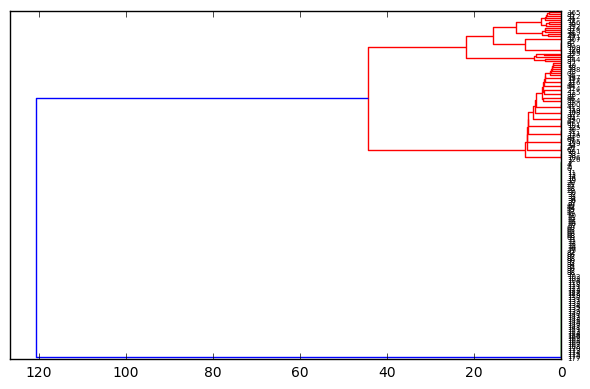

In [30]:
linkage_matrix = ward(dist_eucl)

dendrogram(linkage_matrix, orientation="left")

plt.tight_layout()  # fixes margins

plt.show()

In [118]:
cluster = fcluster(Z=linkage_matrix, t=0.5)      

In [119]:
import collections
d={}
for tweetid, clusterid in enumerate(cluster):
    if not clusterid in d: d[clusterid]=[]
    d[clusterid].append(tweetid)
print(d)

{1: [9, 25, 80, 109, 120, 169], 2: [107, 171], 3: [74, 89, 150], 4: [23, 152], 5: [38, 53, 106, 126], 6: [39], 7: [156], 8: [26, 54, 62, 161], 9: [119], 10: [64, 84, 105, 159], 11: [31, 70, 111, 136], 12: [61, 67, 101, 125], 13: [35, 155], 14: [22], 15: [12], 16: [83, 164], 17: [24], 18: [46, 81], 19: [8], 20: [108, 149, 172], 21: [18, 115], 22: [2, 124], 23: [112], 24: [41, 100, 113], 25: [44, 48], 26: [116, 117], 27: [15, 157], 28: [0, 59], 29: [78, 114], 30: [138, 144], 31: [91, 92], 32: [1, 3, 4, 5, 6, 7, 11, 13, 14, 16, 19, 20, 21, 27, 28, 29, 30, 32, 33, 34, 36, 37, 40, 42, 43, 45, 47, 49, 50, 51, 52, 55, 56, 57, 60, 63, 65, 66, 68, 69, 71, 72, 73, 75, 76, 77, 79, 82, 86, 87, 88, 90, 93, 94, 95, 96, 97, 98, 99, 102, 103, 104, 110, 118, 121, 122, 123, 127, 128, 129, 130, 131, 132, 133, 134, 135, 137, 139, 140, 141, 142, 143, 145, 146, 147, 148, 151, 153, 154, 158, 160, 162, 163, 166, 167, 168, 170, 173, 174, 175, 176, 177], 33: [10], 34: [17], 35: [58], 36: [85], 37: [165]}


In [120]:
cluster_df = pd.DataFrame(columns=['text', 'tweetids'])
cluster_df['text'] = []
cluster_df['tweetids'] = []

In [121]:
rows_list = []
for key, values in d.items():
    text =set()
    ids=[]
    for value in values:
        for word in month['text'][value]:
            text.add(word) 
        ids.append(month['id'][value])
        
    dict1 = {'text':list(text), 'tweetids':ids}

    rows_list.append(dict1)

df = pd.DataFrame(rows_list) 
df

,text,tweetids
0,"[mayor, Phonak, office, couscous, MazeCube, (V...","[9521202348, 9566362388, 9634640721, 967488053..."
1,"[(resto'bar&club), mayor, bar, Lezard, became,...","[9673654499, 9792143909]"
2,"[place, saw, sleep!, watching, [=o)], karma, b...","[9624873202, 9645422855, 9751307332]"
3,"[""Blick"", sehen..., Hand, danach, insider, fb,...","[9564394826, 9762815663]"
4,"[Zattoo, Ab, iPhone, 12, Netlock, Mte, sofort,...","[9579249383, 9588455410, 9673263342, 9721547330]"
5,"[Mobile, local.ch, Bamboo, OVI, success, Andro...",[9580177682]
6,"[vent, prenne, tellement, fb, iPhone, Rhône..,...",[9772616123]
7,"[zrugg, Druck, Beuder, (cont), Olten, wen, mal...","[9566536362, 9590044226, 9614649835, 9777708824]"
8,"[Download, Gratissupport, installier, 10h, mal...",[9692975736]
9,"[Bauhaus, Berne, Station)), route, (Train, Lau...","[9615864211, 9642729143, 9672367874, 9774200592]"


In [104]:

for key, values in d.items():
    for value in values:
        cluster_df.loc(key)['text'] = month['text'][value]
        cluster_df['tweetids'][key].append(month['id'][value])


ValueError: Can only index by location with a [integer, integer slice (START point is INCLUDED, END point is EXCLUDED), listlike of integers, boolean array]

In [31]:
from sklearn.metrics.pairwise import cosine_similarity
dist_cosine = 1 - cosine_similarity(ttm)

In [32]:
np.round(dist_cosine, 2)

array([[ 0.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  0., ...,  1.,  1.,  1.],
       ..., 
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])

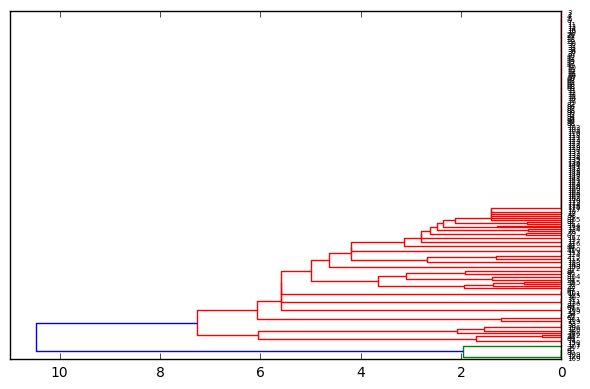

In [33]:
from scipy.cluster.hierarchy import ward, dendrogram
import matplotlib.pyplot as plt

linkage_matrix = ward(dist_cosine)

dendrogram(linkage_matrix, orientation="left")

plt.tight_layout()  # fixes margins

plt.show()